### <font color='darkred'>IA Aplicado a Finanças</font>
### <font color='darkgreen'>Análise de Titulos Publicos ao longo do tempo </font>
### <font color='darkblue'> Análise e tratamento da Estacionaridade na Série Temporal</font>

### <font color='darkred'>Instalando e Carregando os Pacotes</font>

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Imports para manipulação de dados
import pandas as pd
import numpy as np

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para análise e modelagem de séries temporais
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

# Imports para análise de dados/ parte de remover estacionaridade
import scipy
from scipy.stats import boxcox

In [3]:
# Formatando as saídas dos gráficos
plt.style.use('fivethirtyeight')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Michelle Bouhid" --iversions

Author: Michelle Bouhid

matplotlib : 3.7.1
pandas     : 1.5.3
numpy      : 1.23.5
seaborn    : 0.12.2
statsmodels: 0.14.0
scipy      : 1.10.1
platform   : 1.0.8



### <font color='darkred'>Carregando o Conjunto de Dados</font>

In [5]:
# Carrega os dados
dados = pd.read_csv('dados/dataset.csv', header = None)

In [6]:
# Ajustando o nome de cada coluna
dados.columns = ['mes', 'valor_titulo']

In [7]:
# Convertendo a coluna data de object para datetime  
dados['mes'] = pd.to_datetime(dados['mes'], format = '%Y-%m')

In [8]:
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
dados_serie = dados.set_index('mes')

In [9]:
dados_serie.head()

,valor_titulo
mes,
2004-01-01,112
2004-02-01,118
2004-03-01,132
2004-04-01,129
2004-05-01,121


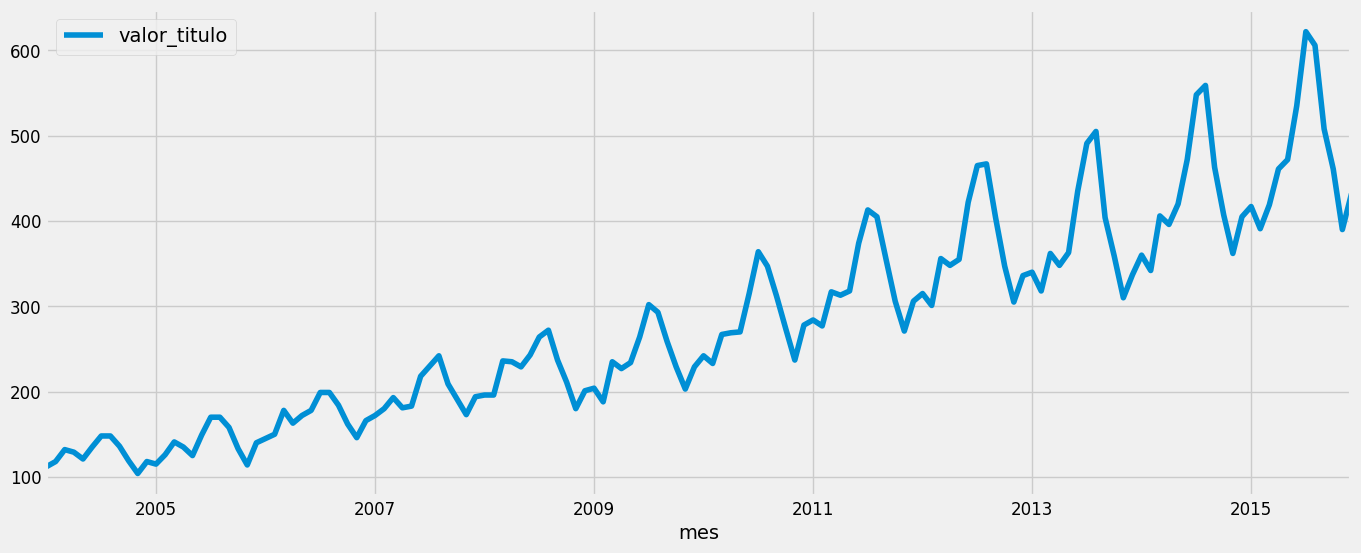

In [10]:
# Plot da série temporal
dados_serie.plot(figsize = (15, 6))
plt.show()

O gráfico acima mostra 2 componentes da série: Sazonalidade e Tendência.

- Sazonalidade - o fenômeno se repete em períodos fixos.

- Tendência - ao longo do tempo, a série segue uma tendência de crescimento.

Como verificamos se a nossa série é estacionária? Precisamos checar algumas suposições e regras.

Antes de iniciar qualquer modelagem preditiva em séries temporais é necessário verificar se essas propriedades estatísticas são constantes na série temporal:

- **Média constante**
- **Variância constante**
- **Autocorrelacionada**

Uma série temporal é considerada estacionária se suas propriedades estatísticas, como média e variância, permanecerem constantes ao longo do tempo.

A maioria dos modelos de séries temporais trabalha com o pressuposto de que a série temporal é estacionária. A principal razão para isso é que existem muitas maneiras pelas quais uma série pode ser não estacionária, mas apenas uma para estacionariedade.

Intuitivamente,  podemos  dizer  que,  se  uma  série  temporal  tem  um  comportamento específico ao longo do tempo, há uma probabilidade muito alta de que ela siga o mesmo no futuro. Além disso, as teorias relacionadas às séries estacionárias são mais maduras e mais fáceis de implementar em comparação às séries não estacionárias.

A estacionariedade é um importante conceito na modelagem de séries temporais e é caracterizada por uma variável que se comporta de forma aleatória ao longo do tempo ao redor de uma média constante.

Basicamente,  séries  temporais  que  possuem  tendência  e/ou  sazonalidade  não  são estacionárias e é necessário o uso de técnicas adequadas a tal situação.

#### <font color = darkgreen> **Podemos verificar a estacionariedade de uma série temporal da seguinte forma:** </font>

> **Plot das Rolling Statistics (Estatísticas Móveis):** Podemos criar um plot da média móvel e variância móvel (ou desvio padrão, que é a raiz quadrada da variância) e ver se variam com o tempo. 
A média / variância móvel é, para qualquer instante 't', a média / variância do último ano, ou seja, os últimos 12 meses. 

> **Autocorrelação com Gráficos ACF e PACF:** Se a série temporal for estacionária, os gráficos ACF  /  PACF  (gráficos  de  autocorrelação  da  série)  mostrarão  um  padrão  específico  o  qual discutiremos mais adiante.

> **Teste Dickey-Fuller:** Este é um dos testes estatísticos para verificar a estacionariedade. Aqui, a hipótese nula é que a série temporal não é estacionária. Os resultados do teste incluem uma estatística de teste e alguns valores críticos para os níveis de confiança das diferenças. Se a 'Estatística de teste' for menor que o 'valor crítico', podemos rejeitar a hipótese nula e dizer que a  série  é  estacionária. 

#### <font color = darkgreen> **Função de Autocorrelação - FAC** </font>


Uma maneira de analisar os dados de séries temporais é plotar cada observação contra outra observação que ocorreu algum tempo antes. 

Por exemplo, você pode plotar yt contra yt-1. Nesse caso, yt-1 é o atraso da série, o lag.

As correlações associadas aos gráficos de atraso formam o que é chamado de "função de autocorrelação".  A autocorrelação é quase a mesma que a correlação de Pearson (que usamos em modelos de Regressão). 

No entanto, a autocorrelação é a correlação de uma série temporal com uma cópia atrasada (lag, atraso ou defasagem) de si mesma. A função de autocorrelação (ACF) é o principal método na análise de séries temporais para quantificar o nível de correlação entre uma série e seus atrasos. Esse método é bastante semelhante  (matematicamente e logicamente) ao  coeficiente  de  correlação  de  Pearson amplamente usado em Machine Learning.

> A  autocorrelação  é  definida  como  uma  observação  num  determinado  instante  está relacionada às observações passadas

As observações podem estar autocorrelacionadas em diversas ordens. A autocorrelação de  primeira  ordem  caracteriza  séries  onde  uma  observação  está  correlacionada  com  a observação imediatamente anterior (janeiro e dezembro, por exemplo). 

A autocorrelação de segunda ordem caracteriza séries temporais onde uma observação está correlacionada com as observações a duasunidades de tempo no passado (janeiro e novembro, por exemplo). 

A identificação da autocorrelação é feita através da Função de Autocorrelação (ACF – Autocorrelation Function). Além disso, testes como o de Durbin Watson auxiliam na identificação da autocorrelação de primeira ordem. 

A autocorrelação é uma ferramenta matemática para encontrar padrões de repetição, como a presença de um sinal periódico. Um diagrama de autocorrelações apresenta os valores de autocorrelação de uma amostra versus o intervalo de tempo em que foi calculado. Autocorrelações devem ser próximas de zero para aleatoriedade. 

A ocorrência de não estacionariedade é denotada pela lenta queda da ACF nos primeiros lags da série. Isto significa que a série deve ser diferenciada, e que um modelo ARIMA ou SARIMA deve ser aplicadopara fazer previsões com a série.

### <font color='darkred'>Plot das Rolling Statistics (Estatísticas Móveis)</font>

Primeiro, vamos checar se as estatísticas móveis são ou não constantes ao longo da série temporal.
Vamos abrir uma janela nos dados e desliza-los ao longo do tempo calculando a media

In [11]:
type(dados)

pandas.core.frame.DataFrame

In [12]:
dados.head()

,mes,valor_titulo
0,2004-01-01,112
1,2004-02-01,118
2,2004-03-01,132
3,2004-04-01,129
4,2004-05-01,121


In [13]:
# Determinando estatísticas móveis
#método rolling do Pandas/window 12, desliza a janela por 12 meses
rolmean = dados['valor_titulo'].rolling(window = 12).mean() #rolling media
rolstd = dados['valor_titulo'].rolling(window = 12).std() # rolling standard deviation

In [14]:
# Prepara os dados para o plot
x = dados['mes'].values
y = dados['valor_titulo'].values

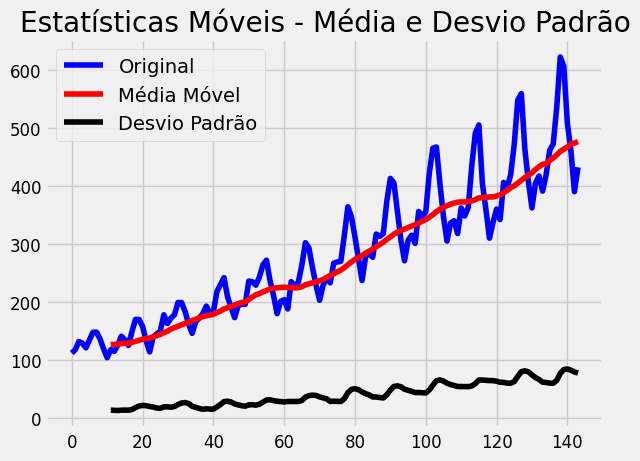

In [15]:
# Plot das estatísticas móveis
orig = plt.plot(y, color = 'blue', label = 'Original')
mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
plt.legend(loc = 'best')
plt.title('Estatísticas Móveis - Média e Desvio Padrão')
plt.show()

Análise:
    
- Observamos que a média móvel e o desvio padrão não são constantes em relação ao tempo (tendência crescente).
- A série cronológica não é, portanto, estacionária.
- a linha vermelha e a linha preta deveriam ser constantes para a media e Dp serem ctes, ié, serie seria estacionária.

### <font color='darkred'>Plots da Função de Autocorrrelação (ACF) e Função de Autocorrelação Parcial (PACF)</font>

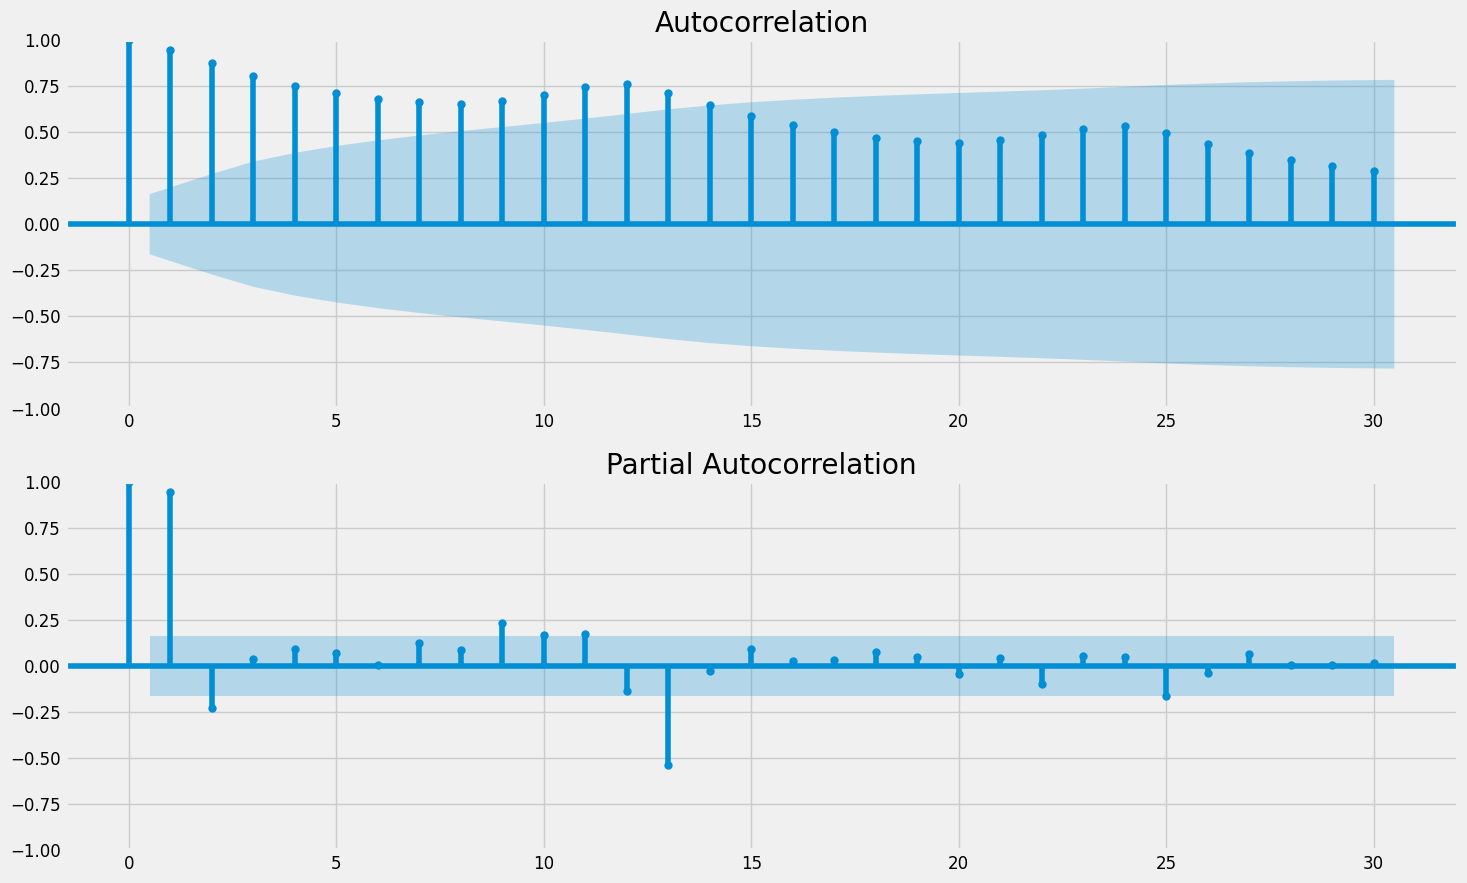

In [16]:
# Plots
plt.rcParams.update({'figure.figsize': (16,10)})

# Plot do gráfico ACF
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
plt.subplot(211)
plot_acf(dados_serie.valor_titulo, ax = plt.gca(), lags = 30)

# Plot do gráfico PACF
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html
plt.subplot(212)
plot_pacf(dados_serie.valor_titulo, ax = plt.gca(), lags = 30, method = 'ywm') #tem que indicar o metodo "ywm"
plt.show()

Interpretação dos Gráficos:

No gráfico, o eixo vertical indica a autocorrelação e o horizontal a defasagem. 

**Autocorrelação (ACF):** Mede a correlação de uma série temporal com seus próprios valores em diferentes defasagens (lags). Em outras palavras, o gráfico de autocorrelação mostra como os valores no tempo t estão correlacionados com os valores no tempo 
t, t−1,t−2,t−3, etc. Se houver alta autocorrelação, isso indica uma dependência temporal entre os pontos ao longo do tempo.

As barras indicam o valor da correlação para cada defasagem. Valores próximos de 1 indicam forte autocorrelação positiva, e valores negativos indicam autocorrelação negativa.

**Interpretação:** Primeiros lags (defasagens): Há uma autocorrelação positiva forte (cerca de 0,9 no lag 1 e caindo gradualmente). A correlação vai diminuindo lentamente, mas ainda permanece significativa para várias defasagens.
Isso sugere que a série temporal apresenta dependência temporal significativa, com padrões que se repetem ao longo do tempo.

**Autocorrelação Parcial (PACF):** A função PACF mede a correlação entre os valores de uma série temporal, mas removendo a influência das autocorrelações de defasagens anteriores. Isso ajuda a identificar a correlação "direta" em uma defasagem específica, ignorando os efeitos de correlações indiretas vindas de defasagens anteriores. Isto é,  **mostra a correlação direta entre o valor atual e o valor de uma defasagem específica, removendo a influência das defasagens intermediárias.**

**Interpretação:** No lag 1, há uma autocorrelação significativa e forte, assim como no gráfico ACF. Para os demais lags, a autocorrelação diminui rapidamente e fica muito próxima de zero para a maioria dos lags (exceto um pico negativo no lag 14).
Isso indica que apenas a primeira defasagem tem uma correlação direta forte, e a maioria das demais correlações para defasagens mais longas é explicada pela defasagem anterior.


**Intervalo de confiança e significância:** Intervalos de confiança (ou nível de significância) são representados pela área sombreada em azul claro em torno de zero. Esses intervalos fornecem um **limite estatístico** dentro do qual os coeficientes de autocorrelação são considerados insignificantes. Se uma barra de autocorrelação ultrapassa os limites do intervalo, podemos dizer que essa defasagem tem uma autocorrelação significativa.

- No gráfico de ACF, as primeiras defasagens estão bem acima do intervalo de confiança, indicando autocorrelação significativa para essas defasagens.

- No PACF, apenas o lag 1 (e um possível outlier no lag 14) ultrapassa esse limite, o que indica que a maioria dos lags subsequentes não apresenta correlação significativa.

Se a ACF decai lentamente e a PACF cai rapidamente após o primeiro lag, isso pode indicar um componente autorregressivo (AR) na série, o que é comum em dados financeiros

> **ACF é útil para verificar a dependência total em várias defasagens, mostrando a correlação total entre t e t−k, considerando todas as defasagens anteriores.. Quando a ACF decai lentamente ao longo das defasagens, isso pode indicar que há uma dependência forte e de longo prazo entre os valores da série.**

> **PACF é mais útil para entender quais defasagens têm uma correlação direta significativa, está mostrando a correlação direta entre t e t−k, para lags de 1 a 30, mas em cada lag, ele elimina as influências de todas as defasagens anteriores, permitindo que você veja quais lags têm uma correlação direta significativa com o valor atual da série.**

Essas duas funções são complementares na análise de séries temporais e ajudam a identificar diferentes tipos de comportamento nos dados, como componentes autorregressivos (AR) e de médias móveis (MA).




1. ACF e PACF – Identificação de Componentes da Série Temporal:
ACF (Autocorrelação) e PACF (Autocorrelação Parcial) são gráficos que ajudam a entender a estrutura de dependência temporal da série. 

Eles são usados principalmente para identificar componentes autorregressivos (AR) e de médias móveis (MA) de um modelo de série temporal, como o ARIMA.

> **A ACF é útil para identificar se a série tem dependências de curto ou longo prazo (especialmente para o componente MA).**

> **A PACF ajuda a identificar o número de lags significativos para um componente AR.**

Interpretação: Se a ACF decai lentamente, isso pode indicar uma não estacionariedade. Se a PACF mostra alguns lags significativos e depois cai abruptamente, isso pode indicar um componente AR na série.

Análise:
    
- Se a série temporal for estacionária, os gráficos do ACF / PACF mostrarão uma "queda rápida na correlação" após um pequeno atraso entre os pontos. Não é o caso em nossos gráficos. A queda lenta (redução do tamanho das barras) indica que essa série não é estacionária.


- Os dados da nossa série não são estacionários, pois um número alto de observações anteriores está correlacionado com valores futuros.


- Intervalos de confiança são desenhados na área azul clara. Por padrão, isso é definido como um intervalo de confiança de 95%, sugerindo que os valores de correlação fora desta área provavelmente são uma correlação e não um acaso estatístico.


- Teremos que transformar essa série em estacionária antes de criar um modelo preditivo. Veremos isso mais adiante.

#### <font color='darkred'>Teste Dickey-Fuller Aumentado</font>

- A intuição por trás do teste é que, se a série for integrada, o nível de atraso da série y (t-1) não fornecerá informações relevantes na previsão da mudança em y (t).


- Hipótese nula (H0): a série temporal não é estacionária.


- (H1) Rejeitar a hipótese nula (ou seja, um valor-p abaixo de 0.05) indicará estacionaridade.

In [17]:
# Teste Dickey-Fuller

# Print
print('\nResultado do Teste Dickey-Fuller:\n')

# Teste
dfteste = adfuller(dados_serie.valor_titulo, autolag = 'AIC')

# Formatando a saída
dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                           'Valor-p',
                                           'Número de Lags Consideradas',
                                           'Número de Observações Usadas'])

# Loop por cada item da saída do teste
for key,value in dfteste[4].items():
    dfsaida['Valor Crítico (%s)'%key] = value

# Print
print (dfsaida)


Resultado do Teste Dickey-Fuller:

Estatística do Teste              0.817848
Valor-p                           0.991919
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64


Análise:

- O Valor-p é maior que 0.05. Não temos evidências para rejeitar a hipótese nula de que a série não é estacionária.

### <font color='darkred'>Automatizando  o Teste de Estacionariedade </font>
E aqui um presente para você. Uma função que executa o teste de estacionaridade e pode ser aplicada a qualquer série para testar se ela é ou não estacionária.

Se a série não for estacionária, teremos que aplicar transformações antes da modelagem. Em nosso exemplo, a série não é estacionária e vamos transformá-la em estacionária mais adiante.

Isso vale para qualquer série temporal em problemas na área de finanças.

In [18]:
# Função
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis junto com a série original
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    
    # Plot
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(dados_serie.valor_titulo, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

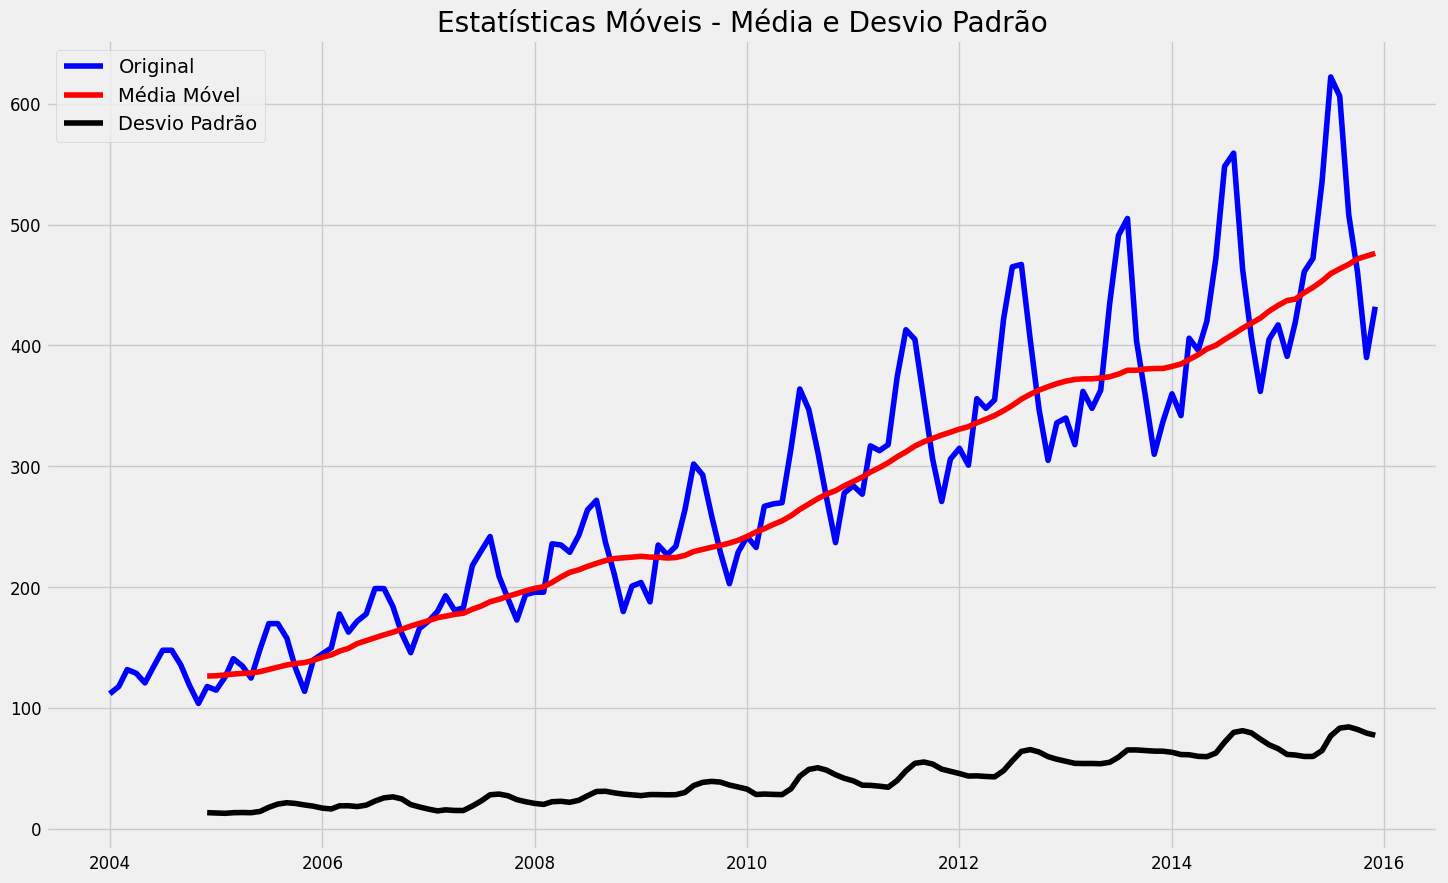


Resultado do Teste Dickey-Fuller:

Estatística do Teste              0.817848
Valor-p                           0.991919
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [19]:
# Executando nossa função
testa_estacionaridade(dados_serie)

**Interpretação do Gráfico:**

- Linha azul (Original): Representa os valores originais da série temporal ao longo do tempo. Podemos ver uma clara tendência de alta (a série apresenta uma inclinação ascendente), além de uma sazonalidade (padrões repetidos em intervalos regulares, com picos e quedas).


- Linha vermelha (Média Móvel): Representa a média móvel ao longo do tempo. O fato de a média estar aumentando constantemente sugere que a série não é estacionária. Para uma série ser estacionária, esperamos que a média se mantenha constante ao longo do tempo, o que não ocorre aqui.


- Linha preta (Desvio Padrão): Representa o desvio padrão móvel da série. Embora o desvio padrão não tenha variações tão grandes quanto a média, ainda há algumas flutuações, o que sugere que a variabilidade da série também não é completamente constante.

### **Teste de Hipótese para o Teste Dickey-Fuller (ADF):**

**Hipótese Nula (H0):** A série não é estacionária (ou seja, a série tem uma raiz unitária).

**Hipótese Alternativa (H1):** A série é estacionária (ou seja, a série não tem uma raiz unitária).

**Critério de Decisão:**
Rejeitar H0 (ou seja, concluir que a série é estacionária) se a estatística de teste for menor que o valor crítico correspondente a um nível de significância (1%, 5%, ou 10%).
Além disso, podemos rejeitar H0 se o valor-p for menor que o nível de significância (geralmente 0.05).

> **Valores obtidos no teste:**

**Estatística de teste: 0.817848**

**Valor-p: 0.991919**

**Valores críticos:**

**Nível de significância**: de 1%: -3.481682 ;  5%: -2.884042 ;  10%: -2.578770

**Decisão:**

Comparando a estatística de teste (0.817848) com os valores críticos, podemos observar que 0.817848 é maior do que os três valores críticos (-3.481682, -2.884042, -2.578770) para os níveis de significância de 1%, 5% e 10%.



Além disso, o **valor-p de 0.991919 é muito maior do que 0.05,** o que significa que não há evidências suficientes para rejeitar a hipótese nula.


**Conclusão:** Não rejeitamos a hipótese nula H0. Isso significa que a série não é estacionária, pois há uma raiz unitária presente. Ou seja, a série apresenta uma tendência ao longo do tempo e sazonalidade, confirmando a não estacionariedade.

## <font color = darkgreen> Mais um pouco de Teoria ! </font>


A fórmula geral do Teste de Dickey-Fuller é:

$$ \Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta \sum_{i=1}^{p} \Delta y_{t-i} + \varepsilon_t $$

Onde:

- \( y_t \) é o valor da série temporal no tempo \( t \)
- \( \Delta y_t \) é a primeira diferença de \( y_t \), ou seja, \( y_t - y_{t-1} \)
- \( \alpha \) é a constante (intercepto)
- \( \beta t \) é o termo de tendência
- \( \gamma \) é o coeficiente de \( y_{t-1} \), e seu valor é usado para testar se a série tem raiz unitária (não estacionária)
- \( \sum_{i=1}^{p} \Delta y_{t-i} \) representa as defasagens das diferenças da série, para eliminar autocorrelações nos resíduos
- \( \varepsilon_t \) é o termo de erro

O teste verifica se o coeficiente \( \gamma \) é significativamente diferente de zero:

- \( H_0: \gamma = 0 \) (a série tem raiz unitária, ou seja, não é estacionária)
- \( H_1: \gamma \neq 0 \) (a série é estacionária)




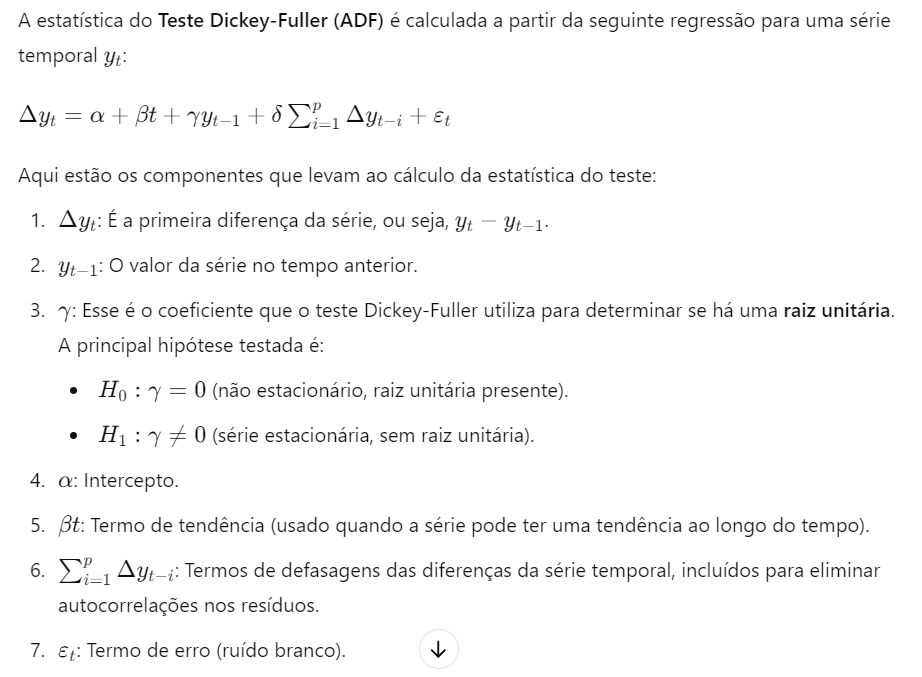

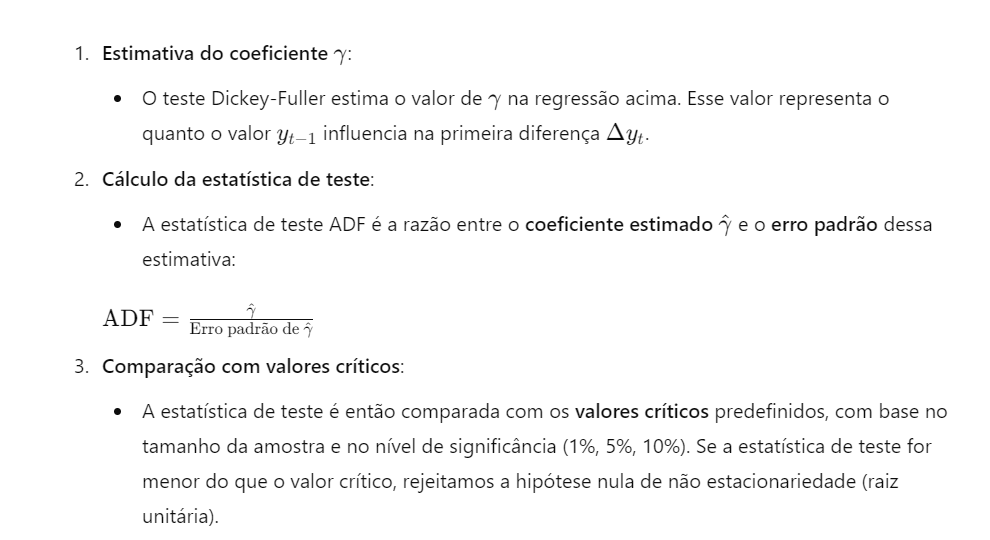

A estatística do teste calculada foi 0.817848. Isso significa que o coeficiente estimado γ^,  foi positivo, mas não significativamente diferente de zero, com base no valor do erro padrão. Como resultado, não foi possível rejeitar a hipótese nula de que a série tem uma raiz unitária (não estacionária).

A **estacionariedade** de uma série temporal implica que as propriedades estatísticas — como média, variância e autocorrelação — não mudam ao longo do tempo. Para muitas técnicas de análise de séries temporais, como os modelos ARIMA, a suposição de **estacionariedade fraca** é essencial. Isso significa que:

- A série tem **média constante**.
- A **variância é constante** ao longo do tempo.
- A **autocorrelação** depende apenas da distância entre os pontos no tempo, e não do tempo em que ocorrem.

### Principais causas da não estacionariedade:
1. **Tendência**: Uma **média variável ao longo do tempo**. Por exemplo, o valor dos títulos públicos que cresce continuamente ao longo do tempo.
2. **Sazonalidade**: **Padrões cíclicos que se repetem em intervalos regulares**. Por exemplo, se há picos de compras de títulos públicos em determinados meses do ano, por causa de eventos como bonificações ou feriados.

### Tipos de estacionariedade:
1. **Estacionariedade Estrita**: Uma definição matemática rigorosa que exige que a média, variância e covariância da série não dependam do tempo.
2. **Estacionariedade Fraca (ou de Segunda Ordem)**: Requer que a média, variância e covariância da série sejam constantes ao longo do tempo.
3. **Estacionariedade de Tendência**: Uma série que exibe tendência ao longo do tempo pode ser **transformada em estacionária** ao remover essa tendência, seja por diferenciação ou ajuste de um modelo de tendência. A série original **não é estacionária**, mas pode se tornar estacionária após o tratamento da tendência.


Se a série temporal não for estacionária, podemos frequentemente transformá-la em estacionária com uma das técnicas seguintes (ou combinações delas):

1. **Transformações de Potência**: Aplicamos transformações matemáticas para estabilizar a variância e remover grandes flutuações. As transformações de potência mais comuns são:
   - **Logaritmo**: Ajuda a suavizar grandes variações, especialmente em séries com crescimento exponencial.
   - **Raiz Quadrada**: Reduz a amplitude das variações, suavizando as flutuações.
   - **Box-Cox**: Uma transformação mais flexível que permite ajustar a série conforme necessário para estabilizar a variância.


2. **Diferenciação**: Criamos uma nova série subtraindo o valor anterior do valor atual:

   $$ \Delta Y_t = Y_t - Y_{t-1} $$
   
   Isso remove a tendência e pode transformar a série em estacionária. Embora seja possível diferenciar mais de uma vez, uma única diferenciação geralmente é suficiente. Os dados diferenciados conterão um ponto a menos que os dados originais. 
   

3. **Ajuste de Curvas para Remover Tendências**: Se os dados tiverem uma tendência, podemos ajustar uma linha reta ou uma curva aos dados e, em seguida, modelar os resíduos dessa remoção. Os resíduos resultantes devem ser estacionários e podem ser modelados com técnicas como ARIMA.


4. **Tratamento de Dados Negativos**: Para dados negativos, podemos adicionar uma constante para torná-los positivos e permitir a aplicação de transformações como o logaritmo. Após a modelagem, essa constante pode ser subtraída para retornar à escala original.


## <font color = darkgreen>  Agora, vamos trabalhar na transformação da série em estacionária</font>

In [20]:
# Carrega os dados
# Observe que estamos carregando os dados e já definindo a data como índice com o parâmetro index_col = 0
dados = pd.read_csv('dados/dataset.csv', 
                    header = None, 
                    index_col = 0, #coluna de indice zero é a data
                    names = ['valor_titulo'])

In [21]:
# Série
dados.head()

,valor_titulo
2004-01,112
2004-02,118
2004-03,132
2004-04,129
2004-05,121


In [22]:
# tipo dos dados de cada coluna individualmente, pode usar o método dtypes do Pandas
# se quisesse converter em datetime: dados.index = pd.to_datetime(dados.index)
# mas está
dados.dtypes

valor_titulo    int64
dtype: object

In [23]:
# Esse comando retornará o tipo de objeto dos dados
type(dados)


pandas.core.frame.DataFrame

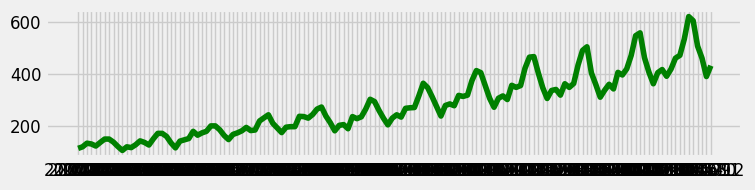

In [24]:
# Área de plotagem
plt.figure(figsize=(8, 4))

# Gráfico de Linha
plt.subplot(211)
plt.plot(dados['valor_titulo'], color = "green")

(array([24., 27., 19., 18., 22., 13., 10.,  6.,  3.,  2.]),
 array([104. , 155.8, 207.6, 259.4, 311.2, 363. , 414.8, 466.6, 518.4,
        570.2, 622. ]),
 <BarContainer object of 10 artists>)

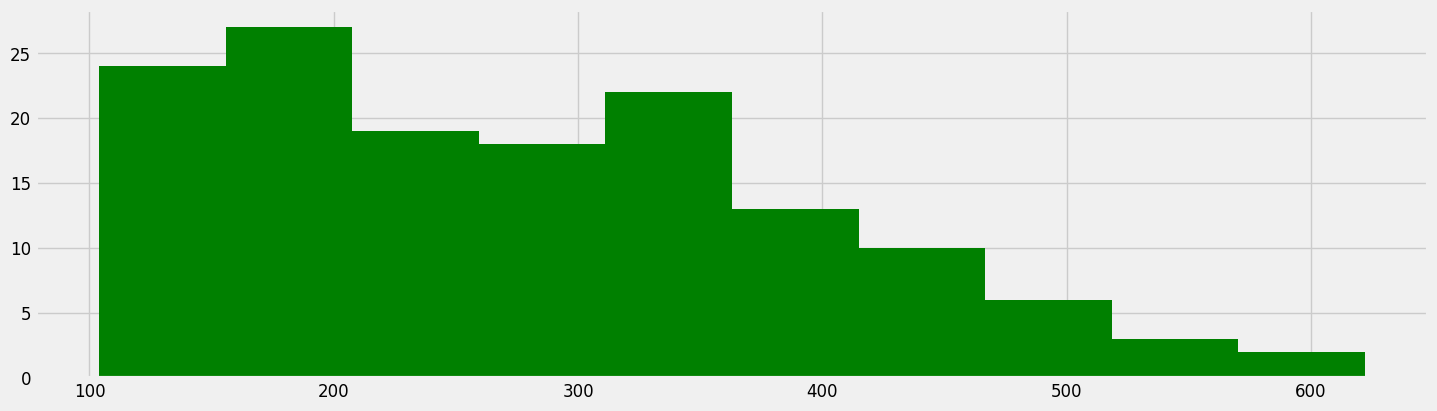

In [25]:
# Histograma
plt.subplot(211)
plt.hist(dados['valor_titulo'], color = "green")

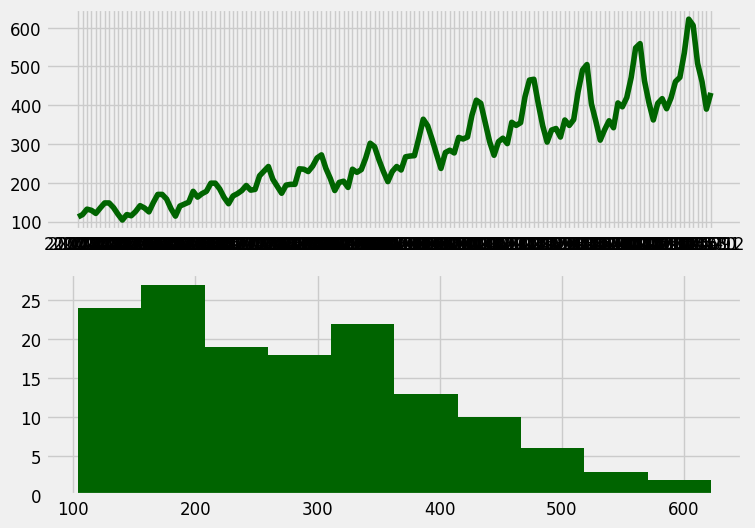

In [26]:
# Gráfico de Linha
plt.figure(figsize=(8, 6))  # Ajustando o tamanho da figura

# Primeiro gráfico - Gráfico de linha
plt.subplot(211)
plt.plot(dados['valor_titulo'], color="darkgreen")

# Segundo gráfico - Histograma
plt.subplot(212)
plt.hist(dados['valor_titulo'], color="darkgreen")

# Exibindo os gráficos
plt.show()


In [27]:
# Média da série
dados['valor_titulo'].mean()

280.3125

In [28]:
# Desvio Padrão da série
dados['valor_titulo'].std()

119.95368970909222

O conjunto de dados é **não estacionário**, o que significa que a média e a variância das observações mudam ao longo do tempo. Isso dificulta a modelagem por métodos estatísticos clássicos, como ARIMA, e métodos mais sofisticados de aprendizado de máquina, como redes neurais.

A não estacionaridade é causada pelo que parece ser uma tendência crescente e um componente de sazonalidade.

Além disso, a quantidade de alteração ou a variância está aumentando com o tempo (o intervalo entre o topo e o fundo vão aumentando). Isso fica claro quando você olha para o tamanho do componente sazonal e percebe que de há um ciclo para o próximo, a amplitude (de baixo para cima do ciclo) está aumentando.

### Principais Técnicas Para Aplicar Estacionaridade:

**Transformação**

- Transformação de log
- Transformação exponencial
- Transformação Box Cox
- Transformação da raiz quadrada

**Remoção de Tendência**

- Smoothing (alisamento ou suavização) é usada para remover a tendência da série, calculando médias contínuas ao longo das janelas de tempo.

Mas as técnicas acima não funcionam em todos os casos, principalmente nos de alta sazonalidade. Para esses casos, outras técnicas podem ser usadas:

**Diferenciação**

- Nesta técnica calculamos a diferença da observação em um determinado instante com a do instante anterior.

**Decomposição**

- Nesta abordagem (que vimos em uma das aulas anteriores), a tendência e a sazonalidade são modeladas separadamente e a parte restante da série é retornada.

Vamos estudandos as técnicas de forma intercambiável, pois elas são melhores usadas quando aplicadas em conjunto. Não sabemos qual técnica vai apresentar o melhor resultado, pois isso sempre depende dos dados.

As transformações são usadas para estabilizar a variação não constante de uma série. Métodos de transformação comuns incluem transformação de log, raiz quadrada e transformação Box-Cox. Vamos começar pela transformação de log em nosso conjunto de dados com os valores de um título público ao longo do tempo.

#### Transformação de Log

Séries temporais podem ser linearizadas usando o logaritmo dos valores. Isso é chamado de transformação de log. 

As transformações de log são populares em dados de séries temporais, pois são eficazes na **remoção da variação exponencial.**

**Coloca os valores na mesma escala**

É importante observar que esta operação assume que os **valores são positivos e diferentes de zero**. É comum transformar observações adicionando uma constante fixa para garantir que todos os valores de entrada atendam a esse requisito. Por exemplo: serie_transformada_y = log(constante + x)

In [29]:
# Vamos aplicar uma transformação de log usando np.log() e gravamos o resultado em uma nova coluna do nosso dataset
dados['valor_titulo_log'] = np.log(dados['valor_titulo'])
dados.head()

,valor_titulo,valor_titulo_log
2004-01,112,4.718499
2004-02,118,4.770685
2004-03,132,4.882802
2004-04,129,4.859812
2004-05,121,4.795791


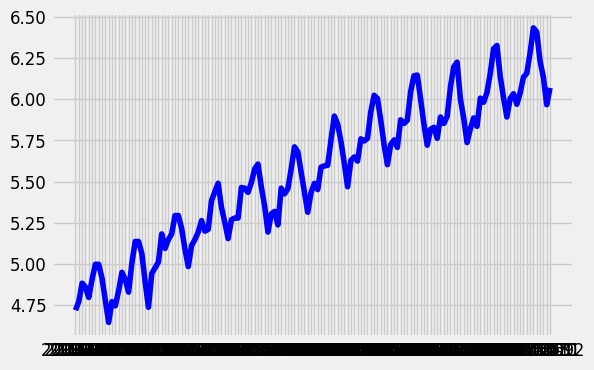

In [30]:
# Plot da série transformada
plt.figure(figsize=(6, 4))  # Largura = 6, Altura = 4
plt.plot(dados['valor_titulo_log'], color = "blue") 

(array([ 8., 14., 11., 20., 16., 15., 27., 17., 11.,  5.]),
 array([4.6443909 , 4.82324582, 5.00210074, 5.18095566, 5.35981058,
        5.5386655 , 5.71752042, 5.89637533, 6.07523025, 6.25408517,
        6.43294009]),
 <BarContainer object of 10 artists>)

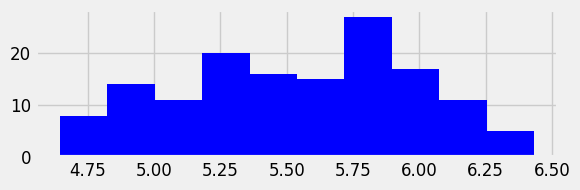

In [31]:
# Histograma da série transformada
plt.figure(figsize=(6, 4))
plt.subplot(211)
plt.hist(dados['valor_titulo_log'], color = "blue")

A transformação logarítmica é um dos métodos mais comuns para lidar com séries temporais que têm crescimento exponencial, pois ajuda a estabilizar a variância e a normalizar os dados.

Gráfico Verde (série original): A distribuição tem uma cauda longa à direita, o que indica que há muitos valores concentrados em torno dos valores mais baixos, com alguns valores muito grandes (distribuição assimétrica).

Gráfico Azul (após log): A distribuição se aproxima mais de uma distribuição normal após a transformação logarítmica. Isso é visível pela forma mais simétrica e equilibrada dos dados, o que indica que a transformação conseguiu suavizar as grandes variações da série original.

In [32]:
# Função
def testa_estacionaridade(serie): # A função recebe uma série temporal como argumento, chamada serie. 
                                    # Essa série é o objeto que será analisado.
    
    from statsmodels.tsa.stattools import adfuller
    
    # Calcula estatísticas móveis - media e desvio padrao
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    
    # Plot
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste - Aplica o teste ADF na série com a escolha automática de lags baseada no critério de informação de Akaike (AIC).
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída - A função retorna uma lista dfteste, com valores:
    # Estatística do teste ADF; Valor-p (p-value); Número de lags usados no teste; Número de observações usadas.
    # Valores críticos para rejeitar a hipótese nula em diferentes níveis (1%, 5%, 10%).
    # e salva em dfsaida
    # Valores críticos para rejeitar a hipótese nula em diferentes níveis (1%, 5%, 10%).
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    # O loop for insere os valores críticos do teste (para 1%, 5% e 10%) na saída formatada (dfsaida)
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

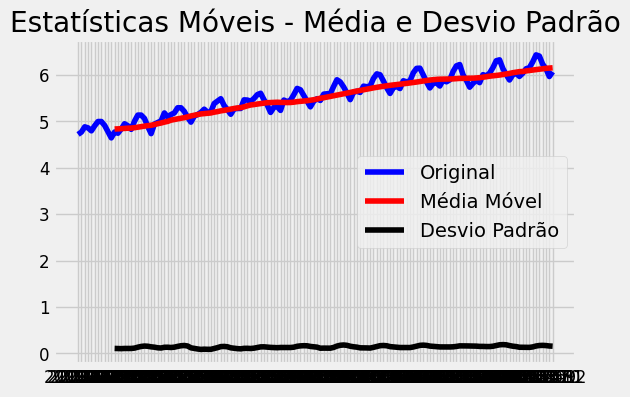


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -1.714743
Valor-p                           0.423533
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [33]:
# dimunuir o tamanho do grafico que foi formatodo no inicio
plt.figure(figsize=(6, 4))  # Definindo a largura = 8 e altura = 4

# A função testa_estacionaridade(serie) espera que você passe uma série temporal como argumento (um objeto pd.Series).
# Chama a funçao testa_estacionaridade e passa como argumento "valor_titulo_log"
testa_estacionaridade(dados['valor_titulo_log'])

### Interpretação do Teste Dickey-Fuller (ADF) após a transformação logarítmica:

#### Resultados do Teste:
- **Estatística do Teste ADF**: -1.714743
- **Valor-p**: 0.423533
- **Valores Críticos**:
  - 1%: -3.481682
  - 5%: -2.884042
  - 10%: -2.578770

#### Hipóteses do Teste Dickey-Fuller:
- **Hipótese Nula (\(H_0\))**: A série tem uma **raiz unitária**, ou seja, **não é estacionária**.
- **Hipótese Alternativa (\(H_1\))**: A série **é estacionária** (não possui raiz unitária).

#### Critério de Decisão:
- Comparamos a **estatística do teste** (-1.714743) com os **valores críticos**. Se a estatística for **menor** do que os valores críticos, rejeitamos a hipótese nula e concluímos que a série é estacionária.
- **Valor-p**: Se o valor-p for **menor do que o nível de significância** (tipicamente 0.05), rejeitamos a hipótese nula.





#### Análise:
1. A **estatística do teste ADF** (-1.714743) **não é menor** do que os valores críticos para nenhum dos níveis de significância (1%, 5%, 10%).
   - Isso significa que a série **não rejeita a hipótese nula** de **não estacionariedade**.
   
2. O **valor-p** é **0.423533**, que é muito maior do que 0.05, o que indica que não temos evidências suficientes para rejeitar a hipótese nula.

#### Conclusão:
- A série **transformada pelo logaritmo ainda não é estacionária**.
- Isso é evidenciado pelo valor alto de **valor-p** e pela estatística do teste que não ultrapassou os valores críticos.

#### Próximos Passos:
- Para tornar a série estacionária, é recomendável aplicar a **diferenciação** para remover a **tendência** residual que ainda aparece na série após a transformação logarítmica.



In [34]:
# Copia do Dataframe
df_teste = dados.copy()

In [35]:
# Aplicando a diferenciação e entendo oq é o shift
# valor do título subtraido dele mesmo menos 1 shift, 1 periodo, (118-112 = 6)
df_teste['valor_titulo_shift'] = df_teste['valor_titulo'] - df_teste['valor_titulo'].shift(1)

In [36]:
df_teste.head()

,valor_titulo,valor_titulo_log,valor_titulo_shift
2004-01,112,4.718499,NaN
2004-02,118,4.770685,6.0
2004-03,132,4.882802,14.0
2004-04,129,4.859812,-3.0
2004-05,121,4.795791,-8.0


In [37]:
# o shift move a série uma unidade no tempo
# Gravamos a série diferenciada no próprio dataset
# Aplicando Diferenciação: Y(i) = Y(i) - Y(i-1) 

dados['valor_titulo_log_diff'] = dados['valor_titulo_log'] - dados['valor_titulo_log'].shift(1)
dados.head()

,valor_titulo,valor_titulo_log,valor_titulo_log_diff
2004-01,112,4.718499,NaN
2004-02,118,4.770685,0.052186
2004-03,132,4.882802,0.112117
2004-04,129,4.859812,-0.022990
2004-05,121,4.795791,-0.064022


(array([ 2., 13., 18., 13., 15., 26., 13., 24., 15.,  4.]),
 array([-0.22314355, -0.17851484, -0.13388613, -0.08925742, -0.04462871,
         0.        ,  0.04462871,  0.08925742,  0.13388613,  0.17851484,
         0.22314355]),
 <BarContainer object of 10 artists>)

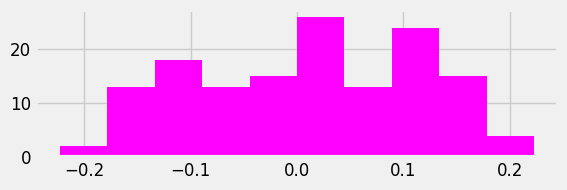

In [38]:
# Histograma da série diferenciada
plt.figure(figsize=(6, 4))
plt.subplot(211)
plt.hist(dados['valor_titulo_log_diff'], color = "magenta")

In [39]:
# Média da série
dados['valor_titulo_log_diff'].mean()

0.009440046971671445

In [40]:
# Desvio Padrão da série
dados['valor_titulo_log_diff'].std()

0.10646598813605124

<Axes: >

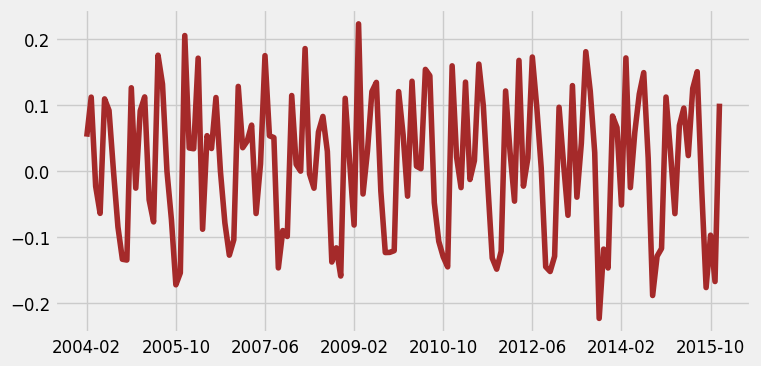

In [41]:
# Perceba que gerou um valor NA
# Isso é normal, pois ao aplicar a Diferenciação perdemos um ponto de dado
# Precisamos tomar cuidado ao criar o plot, removendo o valor NA, criado na diff
plt.figure(figsize=(8, 4))
dados['valor_titulo_log_diff'].dropna().plot(color = "brown")

Comparando com o grafico anterior,  a diferencial tirou completamente a sazonalidade e a tendência.
Mas ainda tem muita variância, não conseguimos estacionaridade ainda!

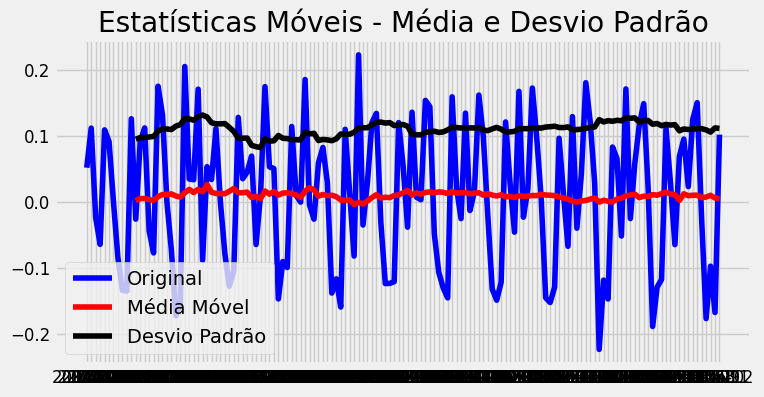


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -2.715922
Valor-p                           0.071323
Número de Lags Consideradas      14.000000
Número de Observações Usadas    128.000000
Valor Crítico (1%)               -3.482501
Valor Crítico (5%)               -2.884398
Valor Crítico (10%)              -2.578960
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [42]:
plt.figure(figsize=(8, 4))
testa_estacionaridade(dados['valor_titulo_log_diff'].dropna())

Análise:

- Como você pode ver, o gráfico é uma melhoria significativa em relação aos gráficos anteriores, mas a variância ainda parece alta. Vamos continuar tentando.

- Ao aplicar transformações, você consegue representar na série apenas o que realmente importa para suas análises: os dados, em nosso caso, o valor do título público ao longo do tempo, sem os componentes trazidos pelo tempo: sazonalidade e tendência.

- Lembre-se que estamos fazendo transformações matematicas, modificamos os dados mas sem perder a informação. Como por exemplo, multiplicar os 2 lados da equaçao, para simplificar a equação. 

### <font color = green> Transformação de Raiz Quadrada </font>


Uma série temporal que tem uma tendência quadrática de crescimento pode ser linearizada calculando sua raiz quadrada.

É possível que nosso conjunto de dados mostre um crescimento quadrático. Se esse for o caso, poderíamos esperar que uma transformação de raiz quadrada, para reduzir a tendência de crescimento, seja linear e alterar a distribuição de observações para talvez ser quase gaussiana.

O exemplo abaixo executa uma raiz quadrada do conjunto de dados e plota os resultados

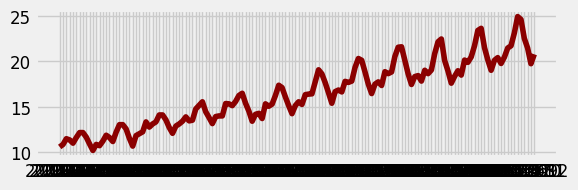

In [43]:
# Transformação de Raiz Quadrada com np.sqrt()
dados_sqrt = np.sqrt(dados['valor_titulo'])

# Gráfico de Linha
plt.figure(figsize=(6, 4))
plt.subplot(211)
plt.plot(dados_sqrt, color = "darkred")

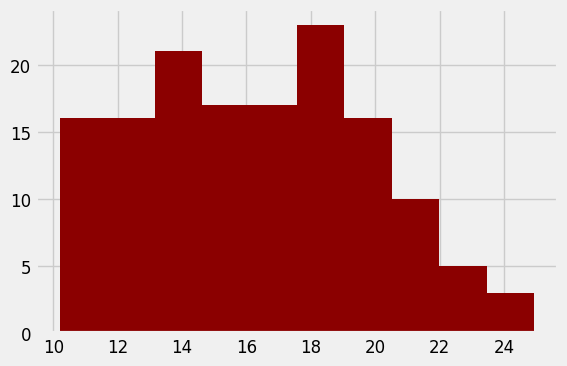

In [44]:
# Histograma
plt.figure(figsize=(6, 4))
plt.hist(dados_sqrt, color = "darkred")
plt.show()

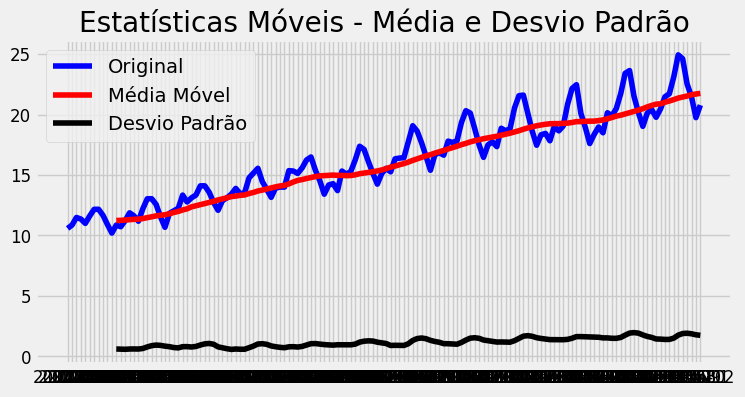


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -0.343797
Valor-p                           0.919068
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [45]:
plt.figure(figsize=(8, 4))
testa_estacionaridade(dados_sqrt)

Análise:

- Podemos ver que a tendência foi reduzida, mas não foi removida.

- O gráfico de linha ainda mostra uma variação crescente de ciclo para ciclo. E o histograma ainda mostra uma cauda longa à direita da distribuição, sugerindo uma distribuição exponencial ou de cauda longa.

- Podemos ver que a tecnica de raiz quadrada não funcionou nessa série temporal.

### <font color = green> Transformação Box-Cox </font>

A transformação de raiz quadrada e a transformação de log pertencem a uma classe de transformações denominadas transformações de potência.

A transformação Box-Cox é um método de transformação de dados configurável que suporta a raiz quadrada e a transformação de log, bem como um conjunto de transformações relacionadas.

Mais do que isso, pode ser configurado para avaliar um conjunto de transformações automaticamente e selecionar o melhor ajuste. A série resultante pode ser mais linear e a distribuição resultante mais gaussiana ou uniforme, dependendo do processo que a gerou.

A biblioteca scipy.stats fornece uma implementação da transformação Box-Cox. A função boxcox() usa um argumento, chamado lambda, que controla o tipo de transformação a ser executada.

Abaixo estão alguns valores comuns para lambda

- lambda = -1. é uma transformação recíproca.
- lambda = -0,5 é uma transformação de raiz quadrada recíproca.
- lambda = 0,0 é uma transformação de log.
- lambda = 0,5 é uma transformação de raiz quadrada.
- lambda = 1.0 não é transformação.

### Transformação Box-Cox

A **Transformação Box-Cox** é uma técnica usada para transformar dados de forma que eles fiquem mais próximos de uma **distribuição normal**. Ela pertence à família das transformações de potência, como a **transformação de log** e a **raiz quadrada**, e seu objetivo é estabilizar a variância, remover a assimetria e melhorar a adequação dos dados a modelos estatísticos, especialmente aqueles que assumem normalidade dos erros, como os modelos de regressão e séries temporais.

#### Principais Características:
- **Reduz a heterocedasticidade**: A Box-Cox é muito eficaz para estabilizar variância. Em séries temporais, quando os dados apresentam maior variabilidade à medida que aumentam (variância não constante), a Box-Cox pode suavizar essa variação.
- **Transforma distribuições assimétricas**: A transformação pode converter distribuições assimétricas em distribuições mais simétricas, aproximando-se de uma distribuição normal.
- **Ajustável**: O parâmetro \(\lambda\) controla o tipo de transformação aplicada. O algoritmo pode selecionar automaticamente o valor de \(\lambda\) que melhor ajusta os dados.

#### Fórmula Geral da Transformação Box-Cox:
A fórmula da transformação Box-Cox para uma variável \(Y\) e parâmetro \(\lambda\) é:

\[
Y_{\text{transformado}} =
\begin{cases} 
\frac{Y^\lambda - 1}{\lambda} & \text{se } \lambda \neq 0 \\
\ln(Y) & \text{se } \lambda = 0
\end{cases}
\]

#### Tipos de Transformação com Base no Valor de \(\lambda\):
A Box-Cox pode realizar diferentes tipos de transformações dependendo do valor do parâmetro \(\lambda\). Aqui estão alguns valores comuns de \(\lambda\) e o que eles significam:
- **\(\lambda = -1\)**: É uma **transformação recíproca** (\(1/Y\)).
- **\(\lambda = -0.5\)**: **Raiz quadrada recíproca** (\(1/\sqrt{Y}\)).
- **\(\lambda = 0\)**: **Transformação de logaritmo** (\(\ln(Y)\)).
- **\(\lambda = 0.5\)**: **Raiz quadrada** (\(\sqrt{Y}\)).
- **\(\lambda = 1\)**: Nenhuma transformação (os dados permanecem inalterados).

#### Quando utilizar a Transformação Box-Cox:
A transformação Box-Cox é recomendada quando:
- **Heterocedasticidade**: Quando a variância dos seus dados não é constante (ou seja, os erros de um modelo possuem variância não constante).
- **Assimetria**: Quando a distribuição dos dados é assimétrica (cauda longa, muito enviesada), e você deseja torná-la mais simétrica.
- **Modelos que requerem normalidade**: Muitos modelos estatísticos, como regressão linear e ARIMA em séries temporais, assumem que os resíduos têm uma distribuição normal. A Box-Cox pode ajudar a ajustar os dados a essa suposição.

#### Exemplo de Aplicação com `scipy.stats.boxcox`:
A função `boxcox()` da biblioteca `scipy.stats` aplica a transformação Box-Cox em seus dados e pode até otimizar automaticamente o valor de \(\lambda\) para melhor ajuste.

Exemplo de uso em Python:

```python
from scipy.stats import boxcox
import numpy as np

# Dados originais
dados = np.array([1, 2, 3, 4, 5])

# Aplicando a transformação Box-Cox
dados_transformados, lambda_otimizado = boxcox(dados)

print(f'Dados transformados: {dados_transformados}')
print(f'Lambda otimizado: {lambda_otimizado}')


In [46]:
# Aplicando Transformação Box-Cox - pacote scipy.stats
dados['valor_titulo_box'] = boxcox(dados['valor_titulo'], lmbda = 0.0)
dados.head()

,valor_titulo,valor_titulo_log,valor_titulo_log_diff,valor_titulo_box
2004-01,112,4.718499,NaN,4.718499
2004-02,118,4.770685,0.052186,4.770685
2004-03,132,4.882802,0.112117,4.882802
2004-04,129,4.859812,-0.022990,4.859812
2004-05,121,4.795791,-0.064022,4.795791


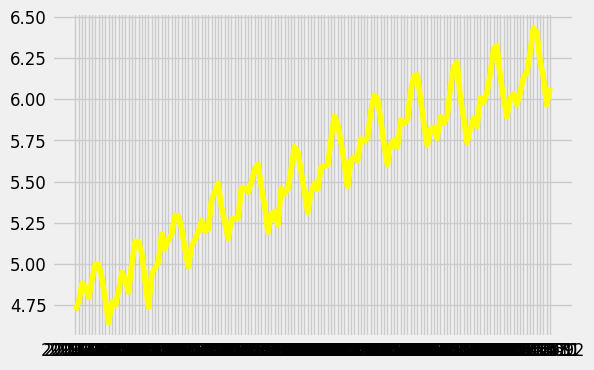

In [47]:
# Plot da série transformada
plt.figure(figsize=(6, 4))
plt.plot(dados['valor_titulo_box'], color = "yellow")

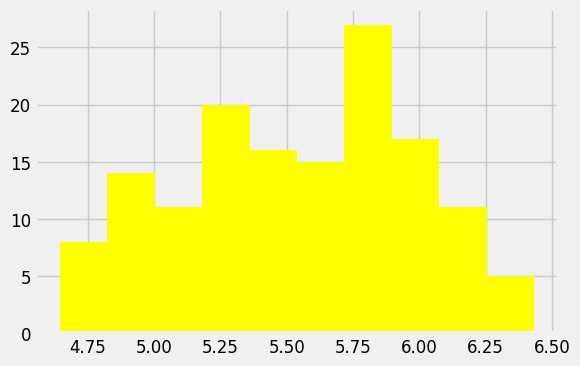

In [48]:
# Histograma
plt.figure(figsize=(6, 4))
plt.hist(dados['valor_titulo_box'], color = "yellow")
plt.show()

Podemos definir o parâmetro lambda como None (o padrão) e deixar a função encontrar um valor ajustado estatisticamente.

O exemplo a seguir demonstra esse uso, retornando o conjunto de dados transformado e o valor lambda escolhido.

In [49]:
# Aplicando Transformação Box-Cox
dados['valor_titulo_box_2'], lam_value = boxcox(dados['valor_titulo'])
print('Valor Ideal de Lambda: %f' % lam_value)
dados.head()

Valor Ideal de Lambda: 0.148174


,valor_titulo,valor_titulo_log,valor_titulo_log_diff,valor_titulo_box,valor_titulo_box_2
2004-01,112,4.718499,NaN,4.718499,6.830212
2004-02,118,4.770685,0.052186,4.770685,6.935620
2004-03,132,4.882802,0.112117,4.882802,7.164857
2004-04,129,4.859812,-0.022990,4.859812,7.117541
2004-05,121,4.795791,-0.064022,4.795791,6.986622


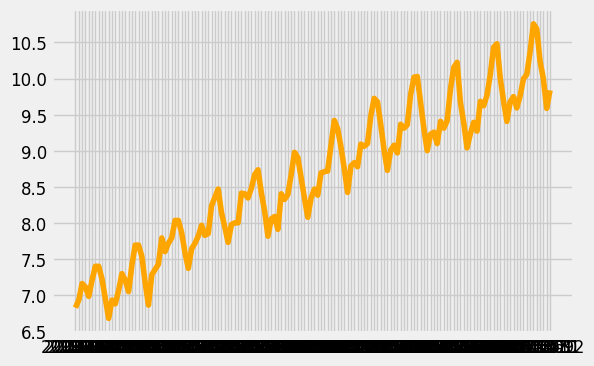

In [50]:
# Plot da série transformada
plt.figure(figsize=(6, 4))
plt.plot(dados['valor_titulo_box_2'], color = "orange")

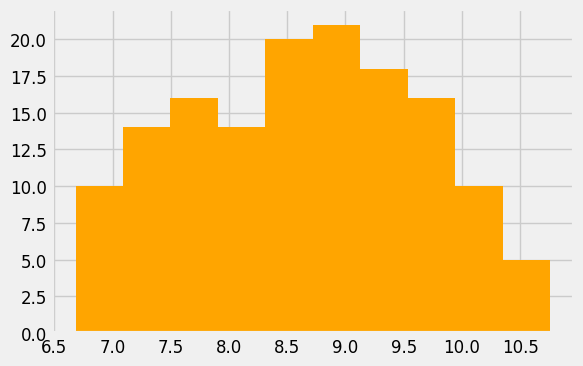

In [51]:
# Histograma
plt.figure(figsize=(6,4))
plt.hist(dados['valor_titulo_box_2'], color = "orange")
plt.show()

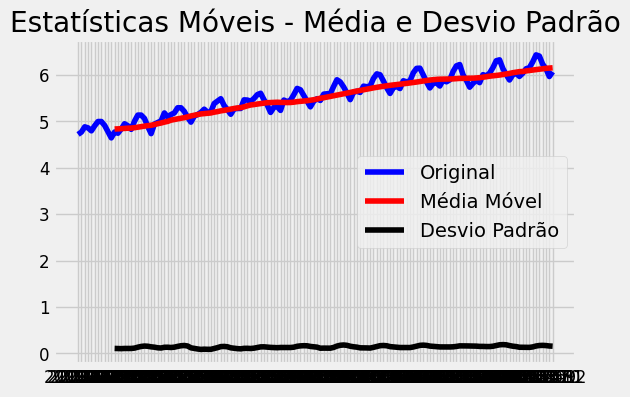


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -1.714743
Valor-p                           0.423533
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [52]:
plt.figure(figsize=(6,4))
testa_estacionaridade(dados['valor_titulo_box'])

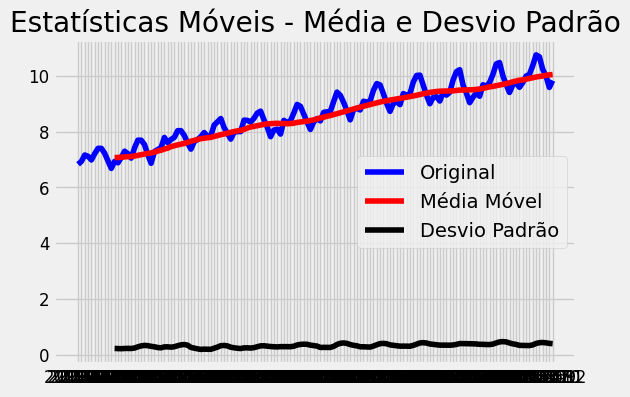


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -1.323590
Valor-p                           0.618312
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [53]:
plt.figure(figsize=(6,4))
testa_estacionaridade(dados['valor_titulo_box_2'])

Análise:

- A execução do exemplo gerou o valor lambda de 0,148.

- Podemos ver que isso está muito próximo de um valor lambda de 0,0, resultando em uma transformação de log mais forte (e menor) que 0.5 para a transformação de raiz quadrada.

Aparentemente nenhuma das técnicas anteriores apresentou resultado para tornar a série estacionária. Mas temos ainda algumas cartas na manga, ou melhor, algumas outras técnicas.